# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:
https://colab.research.google.com/drive/1BZEraP33w9TQfTtrSFUZoTJmMBXuFRU7?usp=sharing

In [ ]:
# html file
%%shell
jupyter nbconvert --to html "/content/Lab5_AnikaMule.ipynb"

[NbConvertApp] Converting notebook /content/Lab5_AnikaMule.ipynb to html
[NbConvertApp] Writing 775775 bytes to /content/Lab5_AnikaMule.html


As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install torchtext==0.6

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
print_ham = True

for line in open('SMSSpamCollection'):
    label = line.split()[0]

    if label == "ham" and print_ham:
        print(f"Non-spam example: {line}")
        print(f"Non-spam label is: {label}")
        print_ham = False

    if label == "spam":
        print(f"Spam example: {line}")
        print(f"Spam label is: {label}")
        break


Non-spam example: ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Non-spam label is: ham
Spam example: spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Spam label is: spam


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
count_spam = 0
count_ham = 0

for line in open('SMSSpamCollection'):
    label = line.split()[0]

    if label == "spam":
        count_spam += 1
    else:
        count_ham += 1

print(f"Number of spam messages: {count_spam}")
print(f"Number of non-spam messages: {count_ham}")


Number of spam messages: 747
Number of non-spam messages: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

## REWRITE

Advantages: One advantage is the reduction in memory requirements. Characters form a smaller and more limited set compared to words, which means fewer unique tokens are needed to represent the entire text. This compact representation is beneficial in environments with limited storage capacity. Character-level modeling excels in handling unknown words. Given the frequent appearance of new words, typos, and informal language in SMS texts, a character-level model is overall better. It can interpret and learn from any sequence of characters, effectively managing words that the model has not encountered before, which ensures the model can generalize better to new or misspelled words, a common occurrence in spam messages.

Disadvantages: The main disadvantage is the increased sequence length. Since a message consists of more characters than words, character-level models need to process longer sequences, leading to longer training times. Similarly character-level models may struggle with understanding semantic context. Words carry more explicit meaning than individual characters, and word-level models can more easily capture relationships and meanings within sentences. So the model can be less efficient and effective in recognizing the meaning of longer phrases. This limitation can affect the model's ability to accurately interpret and differentiate between similar phrases in the context of spam detection.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext
from torchtext.data import Field, TabularDataset

text_field = Field(sequential=True,        # text sequence
                   tokenize=list,          # tokenize as characters
                   include_lengths=True,   # include lengths for batching
                   batch_first=True,       # batch dimension comes first
                   use_vocab=True)         # use a vocabulary to map characters to indices

label_field = Field(sequential=False,      # not a sequence
                    use_vocab=False,       # no vocabulary needed
                    is_target=True,        # this is the target field
                    batch_first=True,      # batch dimension comes first
                    preprocessing=lambda x: int(x == 'spam')) # convert to binary label

fields = [('label', label_field), ('sms', text_field)]

dataset = TabularDataset(path="SMSSpamCollection", # path to the data file
                         format="tsv",             # tab-separated values
                         fields=fields)            # fields definition

# splitting
train, valid, test = dataset.split(split_ratio=[0.6, 0.2, 0.2]) # 60-20-20 split

# print example
print(train[0].sms)
print(train[0].label)

print("\n")

# prinnt size of splits
print(len(train))
print(len(valid))
print(len(test))

['R', 'o', 'f', 'l', ' ', 'b', 'e', 't', 't', 'a', ' ', 'i', 'n', 'v', 'e', 's', 't', ' ', 'i', 'n', ' ', 's', 'o', 'm', 'e', ' ', ' ', 'a', 'n', 't', 'i', ' ', 'a', 'g', 'i', 'n', 'g', ' ', 'p', 'r', 'o', 'd', 'u', 'c', 't', 's']
0


3343
1115
1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

Having a balanced training set is helpful for training the neural network because it ensures that the model is equally exposed to both classes, preventing it from becoming biased towards the majority class and improving its ability to accurately classify both spam and non-spam messages.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
print(text_field.vocab.stoi)
print("\n")
print(text_field.vocab.itos)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7ea6c4776920>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'm': 17, 'c': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, 'b': 25, 'T': 26, '2': 27, '8': 28, 'k': 29, 'v': 30, 'E': 31, '5': 32, 'S': 33, 'C': 34, 'O': 35, 'I': 36, '4': 37, '7': 38, 'A': 39, 'N': 40, '3': 41, 'x': 42, '6': 43, ',': 44, 'R': 45, '!': 46, '9': 47, 'W': 48, 'P': 49, 'U': 50, 'M': 51, 'H': 52, 'L': 53, 'D': 54, 'B': 55, 'G': 56, 'Y': 57, 'F': 58, '?': 59, "'": 60, '/': 61, '£': 62, '-': 63, '&': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'K': 69, 'j': 70, '*': 71, 'J': 72, ')': 73, ';': 74, '+': 75, '"': 76, 'Q': 77, 'q': 78, '(': 79, '#': 80, '=': 81, '@': 82, '>': 83, 'Z': 84, 'ü': 85, 'Ü': 86, '‘': 87, '$': 88, '<': 89, '\x92': 90, '%': 91, '|': 92, '[': 93, ']': 94, '_': 95, '“': 96, '…': 97, '\x93': 98,

The variable "text_field.vocab.stoi" represents a dictionary that maps each character token in the vocabulary to a unique integer index, while the variable "text_field.vocab.itos" represents a list that maps each integer index back to its corresponding character token.

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

The token "unk" represents any unknown character that was not found in the training vocabulary, while the token "pad" is used to pad sequences to ensure they have the same length for batch processing.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
count = 1
for batch in train_iter:
    if count > 10:
        break

    # get max length of input sequences in  batch
    max_length = batch.sms[1][0].item()

    # calculate num of 'pad' tokens in batch
    pad_token_id = text_field.vocab.stoi['<pad>']
    num_pads = 0
    for message_length in batch.sms[1]:
        num_pads += max_length - message_length.item()

    print(f"Batch number: {count} | Max length is: {max_length} | Number of 'pad' tokens is: {int(num_pads)}")

    count += 1


Batch number: 1 | Max length is: 159 | Number of 'pad' tokens is: 2
Batch number: 2 | Max length is: 31 | Number of 'pad' tokens is: 22
Batch number: 3 | Max length is: 126 | Number of 'pad' tokens is: 41
Batch number: 4 | Max length is: 56 | Number of 'pad' tokens is: 25
Batch number: 5 | Max length is: 118 | Number of 'pad' tokens is: 60
Batch number: 6 | Max length is: 26 | Number of 'pad' tokens is: 17
Batch number: 7 | Max length is: 12 | Number of 'pad' tokens is: 165
Batch number: 8 | Max length is: 37 | Number of 'pad' tokens is: 26
Batch number: 9 | Max length is: 35 | Number of 'pad' tokens is: 10
Batch number: 10 | Max length is: 22 | Number of 'pad' tokens is: 0


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

input = len(text_field.vocab.itos)

class RNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1):
        super(RNN, self).__init__()
        self.name = "RNN"
        self.emb = torch.eye(vocab_size)
        self.rnn = nn.GRU(vocab_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        one_hot = self.emb[x]
        output, _ = self.rnn(one_hot)
        out = torch.max(output, dim=1)[0]
        out = self.fc(out)
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_accuracy(model, data_loader, batch_size):
    model.eval()
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in data_loader:
            messages, labels = batch.sms[0], batch.label
            messages, labels = messages.to(device), labels.to(device)

            outputs = model(messages)
            _, predicted_labels = outputs.max(dim=1, keepdim=True)

            correct_predictions += (predicted_labels == labels.view_as(predicted_labels)).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    return accuracy


### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [ ]:
import matplotlib.pyplot as plt

def train_rnn(model, train_data, valid_data, batch_size, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    epochs = []

    train_loader = torchtext.data.BucketIterator(train_data,
                                                 batch_size=batch_size,
                                                 sort_key=lambda x: len(x.sms),
                                                 sort_within_batch=True,
                                                 repeat=False)

    validation_loader = torchtext.data.BucketIterator(valid_data,
                                                 batch_size=batch_size,
                                                 sort_key=lambda x: len(x.sms),
                                                 sort_within_batch=True,
                                                 repeat=False)

    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            messages, labels = batch.sms[0], batch.label
            messages, labels = messages.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(messages)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            valid_loss = 0
            for batch in validation_loader:
                messages, labels = batch.sms[0], batch.label
                messages, labels = messages.to(device), labels.to(device)

                predictions = model(messages)
                loss = criterion(predictions, labels)
                valid_loss += loss.item()

            valid_loss /= len(validation_loader)
            valid_losses.append(valid_loss)

        epochs.append(epoch)

        train_acc.append(get_accuracy(model, train_loader, 64))
        valid_acc.append(get_accuracy(model, validation_loader, 64))

        print(f"Epoch {epoch+1} | Loss: {loss.item():.6f} | Train Accuracy: {train_acc[-1]:.6f} | Validation Accuracy: {valid_acc[-1]:.6f}")

        model_path = f"model_{model.name}_bs{batch_size}_lr{learning_rate}_epoch{epoch}.pth"
        torch.save(model.state_dict(), model_path)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, valid_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, valid_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.show()


Epoch 1 | Loss: 0.703005 | Train Accuracy: 0.521228 | Validation Accuracy: 0.132735
Epoch 2 | Loss: 0.667001 | Train Accuracy: 0.517201 | Validation Accuracy: 0.130045
Epoch 3 | Loss: 0.498103 | Train Accuracy: 0.929183 | Validation Accuracy: 0.882511
Epoch 4 | Loss: 0.321542 | Train Accuracy: 0.929854 | Validation Accuracy: 0.960538
Epoch 5 | Loss: 0.212528 | Train Accuracy: 0.915086 | Validation Accuracy: 0.971300
Epoch 6 | Loss: 0.137199 | Train Accuracy: 0.960228 | Validation Accuracy: 0.965022
Epoch 7 | Loss: 0.253244 | Train Accuracy: 0.958214 | Validation Accuracy: 0.970404
Epoch 8 | Loss: 0.107131 | Train Accuracy: 0.955362 | Validation Accuracy: 0.974888
Epoch 9 | Loss: 0.273779 | Train Accuracy: 0.958550 | Validation Accuracy: 0.974888
Epoch 10 | Loss: 0.054600 | Train Accuracy: 0.966773 | Validation Accuracy: 0.972197
Epoch 11 | Loss: 0.054132 | Train Accuracy: 0.964759 | Validation Accuracy: 0.973094
Epoch 12 | Loss: 0.180895 | Train Accuracy: 0.965934 | Validation Accuracy

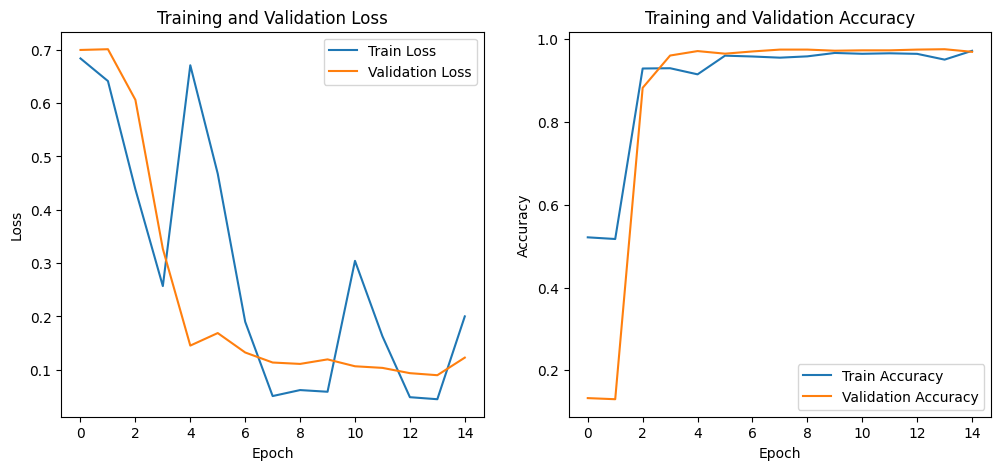

In [ ]:
# hidden units = 100
# batch size = 64
# num_epochs = 15
# learning_rate = 0.0001

model = RNN(input, 100, 2)
train_rnn(model, train, valid, 64, 15, 0.0001)
# RESUKTS: Epoch 15 | Loss: 0.111282 | Train Accuracy: 0.964874 | Validation Accuracy: 0.973094

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [ ]:
# FIRST TRAINING SESSION
# increase number of hidden units
# increase learning rate

# hidden units = 100
# batch size = 64
# num_epochs = 15
# learning_rate = 0.001

# model1 = RNN(input, 500, 2)
# train_rnn(model1, train, valid, 64, 15, 0.001)
# RESULTS: Epoch 15 | Loss: 0.022907 | Train Accuracy: 0.983204 | Validation Accuracy: 0.981166

In [ ]:
# SECOND TRAINING SESSION
# lower number of hidden units
    # doing this because the first training session had lower training and validatyion accuracy than the original results
# increase batch size
# increase number of GRU layers

# hidden units = 300
# batch size = 100
# num_epochs = 15
# learning_rate = 0.001
# GRU layers = 2

# creating new RNN model with 2 GRU layers
input = len(text_field.vocab.itos)

class RNN1(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=2):
        super(RNN1, self).__init__()
        self.name = "RNN1"
        self.emb = torch.eye(vocab_size)
        self.rnn = nn.GRU(vocab_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        one_hot = self.emb[x]
        output, _ = self.rnn(one_hot)
        out = torch.max(output, dim=1)[0]
        out = self.fc(out)
        return out

# model2 = RNN1(input, 300, 2)
# train_rnn(model2, train, valid, 100, 15, 0.001)

# RESULTS: Epoch 15 | Loss: 0.030538 | Train Accuracy: 0.987156 | Validation Accuracy: 0.984753


In [ ]:
# THIRD TRAINING SESSION
# keep number of GRU layers the same since second training session resulted in higher training and validation accuracy than original results
# increase learning rate to imporve training and validation accuracy
# decrease number of epochs to improve speed of runtime

# hidden units = 300
# batch size = 100
# num_epochs = 10
# learning_rate = 0.01
# GRU layers = 2

# model3 = RNN1(input, 300, 2)
# train_rnn(model3, train, valid, 100, 10, 0.01)

# RESULTS: Epoch 10 | Loss: 0.510568 | Train Accuracy: 0.642516 | Validation Accuracy: 0.857399

In [ ]:
# FOURTH (AND LAST) TRAINING SESSION
# keep the second RNN model (with 2 GRU layers) because this resulted in the highest training and validation accuracy
# decrease the learning rate from third training session
    # the highest training and validation accuracy resulted in 0.001 learning rate
    # so in this session, I will slightly increase the learning rate from 0.001 to 0.003

# hidden units = 300
# batch size = 100
# num_epochs = 10
# learning_rate = 0.003
# GRU layers = 2

model4 = RNN1(input, 300, 2)
#train_rnn(model4, train, valid, 100, 10, 0.003)

# RESULTS: Epoch 10 | Loss: 0.006197 | Train Accuracy: 0.988691 | Validation Accuracy: 0.983857

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)

vs = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)


vns = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

input = len(text_field.vocab.itos)  # Example input size
model4 = RNN1(input, 300, 2)
torch.save(model4.state_dict(), "/content/model4")
state = torch.load("model4")
model4.load_state_dict(state)


print("The false positive rate: {}.".format(1 - get_accuracy(model4, vs, 64)))
print("The false negative rate: {}.".format(1 - get_accuracy(model4, vns, 64)))

The false positive rate: 1.0.
The false negative rate: 0.0.


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

A false positive would cause the phone to block an actual message, potentially missing important information from contacts like employers or doctors. Conversely, a false negative would allow a spam message to reach the user, which can be manually deleted by the user but is more disruptive.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_loader = torchtext.data.BucketIterator(test,
                                                 batch_size=100,
                                                 sort_key=lambda x: len(x.sms),
                                                 sort_within_batch=True,
                                                 repeat=False)
test_accuracy = get_accuracy(model4, test_loader,64)
print("The test accuracy the model is:", test_accuracy)


The test accuracy the model is: 0.848294434470377


In [ ]:
best_model = RNN1(input, 300, 2)
best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}.pth".format("RNN", 64, 0.0001, 11)
state = torch.load(best_model_path)
#best_model.load_state_dict(state)

test_accuracy = get_accuracy(best_model, test_loader, 64)
print("test accuracy is:", test_accuracy)

test accuracy is: 0.15170556552962297


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

ts = torchtext.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

tns = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

print("The false positive rate: {}.".format(1 - get_accuracy(best_model, ts, 64)))
print("The false negative rate: {}.".format(1 - get_accuracy(best_model, tns, 64)))

The false positive rate: 0.0.
The false negative rate: 1.0.


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
best_model = RNN1(input, 300, 2)
best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}.pth".format("RNN", 64, 0.0001, 11)
state = torch.load(best_model_path)
#best_model.load_state_dict(state)

msg = "machine learning is sooo cool!"
msg_indices = [text_field.vocab.stoi[char] for char in msg]

# convert to tensor and add batch
msg_tensor = torch.tensor(msg_indices).unsqueeze(0).to(device)

# make prediction
best_model.eval()
output = best_model(msg_tensor)
prob = F.softmax(output, dim=1)
spam_prob = prob[0][1].item()

print("The probability that the message is spam:", spam_prob)

The probability that the message is spam: 0.4945877194404602


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Detecting spam can be pretty straightforward because spam messages often follow certain patterns. While complex models like recurrent neural networks (RNNs) can provide high accuracy, a simple baseline model is useful for initial comparisons and quick evaluations.

To build a simple baseline model for spam detection, you could start with a word frequency analysis. Tokenize the SMS messages into words, and count the frequency of each word in both spam and non-spam datasets. Calculate a spam score for each word based on its frequency in spam messages compared to non-spam messages. You can then classify a message as spam if its total score exceeds a specfied limit.

Similarly, you could also create a basic neural network with a minimal architecture. This network would have an input layer, a basic embedding layer to map words to vectors, and a simple output layer with a sigmoid activation function to predict spam probability. Train this network with a small number of epochs and a low learning rate.